***
# <center><font color = 'Blue'>Data Wrangling Project
## <center>WeRateDogs Data Analysis
***

### Gathering

- Get data from the available csv file: twitter-archive-enhanced.csv
- Use tweepy library to collect number of retweets and favorites of each tweet.
- Use requests library to collect images prediction data saved in Udacity's servers using the given URL.

In [1]:
import pandas as pd
import requests
import tweepy
import os
import json
import numpy as np

#import my config file that contains my secret keys
import config

In [2]:
# Reading the archive file
archive_df = pd.read_csv('twitter-archive-enhanced.csv')

In [3]:
# Getting predictions data and save them in a tsv file
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
file = url.split('/')[-1]
response = requests.get(url)
with open(file, 'wb') as f:
    f.write(response.content)
    

In [4]:
# Reading the created file that holds predictions data
predictions_df = pd.read_csv(file, '\t')

In [5]:
#First check if file exists skip the process (It will not work because twitter configuration will be banned)
if not os.path.isfile('tweet_json.txt'):
    # Get configurations for twitter APIs from my config.py file (this will be replaced by other values when submitting the project)
    api_key = config.Twitter_keys["api_key"]
    api_secret = config.Twitter_keys["api_secret"]
    access_token = config.Twitter_keys["access_token"]
    token_secret = config.Twitter_keys["token_secret"]
    # Twitter API uthentication
    auth = tweepy.OAuthHandler(api_key, api_secret)
    auth.set_access_token(access_token, token_secret)
    api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)
    #The following code is only for experimenting the api and explore the json results 
    try_api = api.get_status(archive_df.tweet_id[0], tweet_mode = 'extended')._json
    print(try_api)
    # Now, back to the work: Loop for each tweet id in the archive dataframe, get the tweet details and save it to a json file.
    errors = []
    with open('tweet_json.txt', 'w') as file:
        for tweet_id in archive_df.tweet_id:
            try:
                tweet = api.get_status(tweet_id, wait_on_rate_limit=True, wait_on_rate_limit_notify=True, tweet_mode = 'extended')._json
                json.dump(tweet, file)
                file.write('\n')
            except Exception as e:
                errors.append({"Tweet_id": tweet_id, "Error:": str(e)})
    errors
    len(errors) #In the first run, there were 24 errors (status not found), and one (You are not authorized to get the status)

In [6]:
tweets_df = pd.read_json('tweet_json.txt', lines=True)
#Checking the code
tweets_df.head(1)

,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,...,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,quoted_status
0,2017-08-01 16:23:56+00:00,892420643555336193,892420643555336192,This is Phineas. He's a mystical boy. Only eve...,False,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN


***
### Assessment

### Assessing archive dataframe

In [7]:
archive_df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [8]:
archive_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [9]:
archive_df.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [10]:
#Check the record with max rating numerator as it is an apparent outlier
archive_df[archive_df.rating_numerator == 1776]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
979,749981277374128128,NaN,NaN,2016-07-04 15:00:45 +0000,"<a href=""https://about.twitter.com/products/tw...",This is Atticus. He's quite simply America af....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/749981277...,1776,10,Atticus,None,None,None,None


In [11]:
#Min and max rating nominator and denominator are unlogic, we need to check them!
archive_df[archive_df['rating_denominator'] == 0]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
313,835246439529840640,8.352460e+17,26259576.0,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@jonnysun @Lin_Manuel ok jomny I know you're e...,NaN,NaN,NaN,NaN,960,0,None,None,None,None,None


In [12]:
#Need to see all the text!
pd.options.display.max_colwidth=150
archive_df[archive_df['rating_denominator']== 0]['text']

313    @jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho
Name: text, dtype: object

In [13]:
archive_df[archive_df['rating_numerator'] == 0]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
315,835152434251116546,NaN,NaN,2017-02-24 15:40:31 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",When you're so blinded by your systematic plagiarism that you forget what day it is. 0/10 https://t.co/YbEJPkg4Ag,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/835152434251116546/photo/1,https://twitter.com/dog_rates/status/835152434251116546/photo/1,https://twitter.co...",0,10,None,None,None,None,None
1016,746906459439529985,7.468859e+17,4.196984e+09,2016-06-26 03:22:31 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","PUPDATE: can't see any. Even if I could, I couldn't reach them to pet. 0/10 much disappointment https://t.co/c7WXaB2nqX",NaN,NaN,NaN,https://twitter.com/dog_rates/status/746906459439529985/photo/1,0,10,None,None,None,None,None


In [14]:
archive_df[archive_df['rating_denominator'] >10]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
342,832088576586297345,8.320875e+17,3.058208e+07,2017-02-16 04:45:50 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@docmisterio account started on 11/15/15,NaN,NaN,NaN,NaN,11,15,None,None,None,None,None
433,820690176645140481,NaN,NaN,2017-01-15 17:52:40 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/820690176645140481/photo/1,https://twitter.com/dog_rates/status/820690176645140481/photo/1,https://twitter.co...",84,70,None,None,None,None,None
784,775096608509886464,NaN,NaN,2016-09-11 22:20:06 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/…",7.403732e+17,4.196984e+09,2016-06-08 02:41:38 +0000,"https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.co...",9,11,None,None,None,None,None
902,758467244762497024,NaN,NaN,2016-07-28 01:00:57 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,NaN,NaN,NaN,https://twitter.com/dog_rates/status/758467244762497024/video/1,165,150,None,None,None,None,None
1068,740373189193256964,NaN,NaN,2016-06-08 02:41:38 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.co...",9,11,None,None,None,None,None
1120,731156023742988288,NaN,NaN,2016-05-13 16:15:54 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,NaN,NaN,NaN,https://twitter.com/dog_rates/status/731156023742988288/photo/1,204,170,this,None,None,None,None
1165,722974582966214656,NaN,NaN,2016-04-21 02:25:47 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,NaN,NaN,NaN,https://twitter.com/dog_rates/status/722974582966214656/photo/1,4,20,None,None,None,None,None
1202,716439118184652801,NaN,NaN,2016-04-03 01:36:11 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,NaN,NaN,NaN,https://twitter.com/dog_rates/status/716439118184652801/photo/1,50,50,Bluebert,None,None,None,None
1228,713900603437621249,NaN,NaN,2016-03-27 01:29:02 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,NaN,NaN,NaN,https://twitter.com/dog_rates/status/713900603437621249/photo/1,99,90,None,None,None,None,None
1254,710658690886586372,NaN,NaN,2016-03-18 02:46:49 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12,NaN,NaN,NaN,https://twitter.com/dog_rates/status/7106586908865

In [15]:
archive_df.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2055,671362598324076544,NaN,NaN,2015-11-30 16:18:11 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Tanner. He accidentally dropped all his hard-earned Kohl's cash in the tub. 11/10 https://t.co/onC3uMpFF2,NaN,NaN,NaN,https://twitter.com/dog_rates/status/671362598324076544/photo/1,11,10,Tanner,None,None,None,None
1016,746906459439529985,7.468859e+17,4.196984e+09,2016-06-26 03:22:31 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","PUPDATE: can't see any. Even if I could, I couldn't reach them to pet. 0/10 much disappointment https://t.co/c7WXaB2nqX",NaN,NaN,NaN,https://twitter.com/dog_rates/status/746906459439529985/photo/1,0,10,None,None,None,None,None
2282,667211855547486208,NaN,NaN,2015-11-19 05:24:37 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Genevieve. She is a golden retriever cocktail mix. Comfortable close to wall. Shows no emotions. 9/10 https://t.co/azEoGqVonH,NaN,NaN,NaN,https://twitter.com/dog_rates/status/667211855547486208/photo/1,9,10,Genevieve,None,None,None,None
1632,684460069371654144,NaN,NaN,2016-01-05 19:42:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Jeph. He's a Western Sagittarius Dookmarriot. Frightened by leaf. Caught him off guard. 10/10 calm down Jeph https://t.co/bicyOV6lju,NaN,NaN,NaN,https://twitter.com/dog_rates/status/684460069371654144/photo/1,10,10,Jeph,None,None,None,None
969,750132105863102464,NaN,NaN,2016-07-05 01:00:05 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Stewie. He will roundhouse kick anyone who questions his independence. 11/10 free af https://t.co/dDx2gKefYo,NaN,NaN,NaN,https://twitter.com/dog_rates/status/750132105863102464/photo/1,11,10,Stewie,None,None,None,None


In [16]:
archive_df[['text','name','rating_numerator', 'rating_denominator']]

,text,name,rating_numerator,rating_denominator
0,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,Phineas,13,10
1,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https:/...",Tilly,13,10
2,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,Archie,12,10
3,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,Darla,13,10
4,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https:/...",Franklin,12,10
...,...,...,...,...
2351,Here we have a 1949 1st generation vulpix. Enjoys sweat tea and Fox News. Cannot be phased. 5/10 https://t.co/4B7cOc1EDq,None,5,10
2352,This is a purebred Piers Morgan. Loves to Netflix and chill. Always looks like he forgot to unplug the iron. 6/10 https://t.co/DWnyCjf2mx,a,6,10
2353,Here is a very happy pup. Big fan of well-maintained decks. Just look at that tongue. 9/10 would cuddle af https://t.co/y671yMhoiR,a,9,10
2354,This is a western brown Mitsubishi terrier. Upset about leaf. Actually 2 dogs here. 7/10 would walk the shit out of https://t.co/r7mOb2m0UI,a,7,10


***
### Assessing predictions data

In [17]:
predictions_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [18]:
predictions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [19]:
predictions_df.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [20]:
predictions_df['p1'].value_counts()

golden_retriever      150
Labrador_retriever    100
Pembroke               89
Chihuahua              83
pug                    57
                     ... 
grey_fox                1
radio_telescope         1
walking_stick           1
bookshop                1
clumber                 1
Name: p1, Length: 378, dtype: int64

In [21]:
predictions_df[predictions_df['p1']=='tricycle']

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
2013,879376492567855104,https://pbs.twimg.com/media/DDQsQGFV0AAw6u9.jpg,1,tricycle,0.663601,False,Labrador_retriever,0.033496,True,Pembroke,0.018827,True


In [22]:
predictions_df[predictions_df['p1']=='studio_couch']

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1165,735274964362878976,https://pbs.twimg.com/media/CjQ4radW0AENP-m.jpg,1,studio_couch,0.944692,False,four-poster,0.007942,False,quilt,0.006302,False


In [23]:
predictions_df[~predictions_df['p1_dog'] & ~predictions_df['p2_dog'] & ~predictions_df['p3_dog']]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
17,666104133288665088,https://pbs.twimg.com/media/CT56LSZWoAAlJj2.jpg,1,hen,0.965932,False,cock,0.033919,False,partridge,0.000052,False
18,666268910803644416,https://pbs.twimg.com/media/CT8QCd1WEAADXws.jpg,1,desktop_computer,0.086502,False,desk,0.085547,False,bookcase,0.079480,False
21,666293911632134144,https://pbs.twimg.com/media/CT8mx7KW4AEQu8N.jpg,1,three-toed_sloth,0.914671,False,otter,0.015250,False,great_grey_owl,0.013207,False
25,666362758909284353,https://pbs.twimg.com/media/CT9lXGsUcAAyUFt.jpg,1,guinea_pig,0.996496,False,skunk,0.002402,False,hamster,0.000461,False
...,...,...,...,...,...,...,...,...,...,...,...,...
2021,880935762899988482,https://pbs.twimg.com/media/DDm2Z5aXUAEDS2u.jpg,1,street_sign,0.251801,False,umbrella,0.115123,False,traffic_light,0.069534,False
2022,881268444196462592,https://pbs.twimg.com/media/DDrk-f9WAAI-WQv.jpg,1,tusker,0.473303,False,Indian_elephant,0.245646,False,ibex,0.055661,False
2046,886680336477933568,https://pbs.twimg.com/media/DE4fEDzWAAAyHMM.jpg,1,convertible,0.738995,False,sports_car,0.139952,False,car_wheel,0.044173,False
2052,887517139158093824,https://pbs.twimg.com/ext_tw_video_thumb/887517108413886465/pu/img/WanJKwssZj4VJvL9.jpg,1,limousine,0.130432,False,tow_truck,0.029175,False,shopping_cart,0.026321,False


***
### Assessing tweets data

In [24]:
tweets_df.head()

,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,...,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,quoted_status
0,2017-08-01 16:23:56+00:00,892420643555336193,892420643555336192,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,False,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 892420639486877696, 'id_str': '892420639486877696', 'indices': [...","{'media': [{'id': 892420639486877696, 'id_str': '892420639486877696', 'indices': [86, 109], 'media_url': 'http://pbs.twimg.com/media/DGKD1-bXoAAIA...","<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
1,2017-08-01 00:17:27+00:00,892177421306343426,892177421306343424,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https:/...",False,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 892177413194625024, 'id_str': '892177413194625024', 'indices': [...","{'media': [{'id': 892177413194625024, 'id_str': '892177413194625024', 'indices': [139, 162], 'media_url': 'http://pbs.twimg.com/media/DGGmoV4XsAAU...","<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
2,2017-07-31 00:18:03+00:00,891815181378084864,891815181378084864,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,False,"[0, 121]","{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 891815175371796480, 'id_str': '891815175371796480', 'indices': [...","{'media': [{'id': 891815175371796480, 'id_str': '891815175371796480', 'indices': [122, 145], 'media_url': 'http://pbs.twimg.com/media/DGBdLU1WsAAN...","<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
3,2017-07-30 15:58:51+00:00,891689557279858688,891689557279858688,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,False,"[0, 79]","{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 891689552724799489, 'id_str': '891689552724799489', 'indices': [...","{'media': [{'id': 891689552724799489, 'id_str': '891689552724799489', 'indices': [80, 103], 'media_url': 'http://pbs.twimg.com/media/DF_q7IAWsAEuu...","<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
4,2017-07-29 16:00:24+00:00,891327558926688256,891327558926688256,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https:/...",False,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': [129, 138]}], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 891327551943041024, '...","{'media': [{'id': 891327551943041024, 'id_str': '891327551943041024', 'indices': [139, 162], 'media_url': 'http://pbs.twimg.com/media/DF6hr6AVYAAZ...","<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN


In [25]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 32 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   created_at                     2331 non-null   datetime64[ns, UTC]
 1   id                             2331 non-null   int64              
 2   id_str                         2331 non-null   int64              
 3   full_text                      2331 non-null   object             
 4   truncated                      2331 non-null   bool               
 5   display_text_range             2331 non-null   object             
 6   entities                       2331 non-null   object             
 7   extended_entities              2059 non-null   object             
 8   source                         2331 non-null   object             
 9   in_reply_to_status_id          77 non-null     float64            
 10  in_reply_to_status_id_st

In [26]:
tweets_df.describe()

,id,id_str,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,geo,coordinates,contributors,retweet_count,favorite_count,possibly_sensitive,possibly_sensitive_appealable,quoted_status_id,quoted_status_id_str
count,2.331000e+03,2.331000e+03,7.700000e+01,7.700000e+01,7.700000e+01,7.700000e+01,0.0,0.0,0.0,2331.000000,2331.000000,2197.0,2197.0,2.600000e+01,2.600000e+01
mean,7.419079e+17,7.419079e+17,7.440692e+17,7.440692e+17,2.040329e+16,2.040329e+16,NaN,NaN,NaN,2634.172029,7409.513943,0.0,0.0,8.113972e+17,8.113972e+17
std,6.823170e+16,6.823170e+16,7.524295e+16,7.524295e+16,1.260797e+17,1.260797e+17,NaN,NaN,NaN,4454.870003,11509.039496,0.0,0.0,6.295843e+16,6.295843e+16
min,6.660209e+17,6.660209e+17,6.658147e+17,6.658147e+17,1.185634e+07,1.185634e+07,NaN,NaN,NaN,1.000000,0.000000,0.0,0.0,6.721083e+17,6.721083e+17
25%,6.782670e+17,6.782670e+17,6.757073e+17,6.757073e+17,3.589728e+08,3.589728e+08,NaN,NaN,NaN,535.000000,1287.000000,0.0,0.0,7.761338e+17,7.761338e+17
50%,7.182469e+17,7.182469e+17,7.032559e+17,7.032559e+17,4.196984e+09,4.196984e+09,NaN,NaN,NaN,1231.000000,3218.000000,0.0,0.0,8.281173e+17,8.281173e+17
75%,7.986692e+17,7.986692e+17,8.233264e+17,8.233264e+17,4.196984e+09,4.196984e+09,NaN,NaN,NaN,3058.000000,9065.000000,0.0,0.0,8.637581e+17,8.637581e+17
max,8.924206e+17,8.924206e+17,8.862664e+17,8.862664e+17,8.405479e+17,8.405479e+17,NaN,NaN,NaN,75682.000000,152889.000000,0.0,0.0,8.860534e+17,8.860534e+17


#### Quality Issues

#### archive_df:
- Data include retweets and replies.
- Existing tweets without images.
- Incorrect data types for: in_reply_to_status_id, in_reply_to_user_id, timestamp, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp.
- The four categories of dogs columns are all not null, although they are expected to be mutially exclusive. This is because of the value "None" instead of null.
- Tweet rating of 0 in denominator need to be modified.
- Tweet ratings with denominator value other than 10, some of them not representing ratings, others need to be normalized to be able to compare them to other values.
- Tweet rating with a very large numerator (apparent outlier).
- Some names are not accurate ('a', 'this').
#### predictions_df:
- Column names are not meaningful.
- Only 2075 records, while 2356 record in archive_df <font color = 'red'>(This will be intentionally ignored as we don't have the predictions algorithm) </font>. 
- 324 predictions have no dog predictions (the 3 predictions have false dog flags), although some of them have dogs like (880935762899988482) others are not like (666293911632134144).<font color = 'red'>(This will be intentionally ignored as we don't have the predictions algorithm) </font>. 
- Predictions with first prediction not a dog.
#### retweets_df
- We only need the tweet_id, favorite_count and retweet_count from the dataframe.

#### Tidiness issues

- Dog categories need to be merged in one column (type) with categorical values: Doggo, Floofer, Pupper and Puppo.
- Many unneeded colulmns in archive_df.
- Different predictions can be in different rows instead of columns <font color = 'red'>(This will be intentionally igmored as I will use only the archive dataframe)</font>.
- To simplify the analysis, the highest confidence dog prediction needs to be added to the archive_df.
- The retweet_count and favorite_count need to be added to the archive_df.

***
### Cleaning

<font color = 'red'>**First step:**</font> getting **copies** from the three dataframes

In [27]:
archive_c = archive_df.copy()
predictions_c = predictions_df.copy()
tweets_c = tweets_df.copy() 

<font color = 'red'>**Second step:**</font> Remove unneeded rows and columns

<font color = 'blue'>**1- Data include retweets and replies.<br/>
    2- Existing tweets without images.**</font>
#### Define:
- Remove retweets and replies (rows with in_reply_to_status_id is not null or retweeted_status_id is not null)
- Remove retweets without images (Null expanded URLs)

#### Code:

In [28]:
archive_c = archive_c[archive_c.in_reply_to_status_id.isnull() & archive_c.retweeted_status_id.isnull()]
archive_c = archive_c[~archive_c.expanded_urls.isnull()]

#### Test:

In [29]:
archive_c.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2094 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2094 non-null   int64  
 1   in_reply_to_status_id       0 non-null      float64
 2   in_reply_to_user_id         0 non-null      float64
 3   timestamp                   2094 non-null   object 
 4   source                      2094 non-null   object 
 5   text                        2094 non-null   object 
 6   retweeted_status_id         0 non-null      float64
 7   retweeted_status_user_id    0 non-null      float64
 8   retweeted_status_timestamp  0 non-null      object 
 9   expanded_urls               2094 non-null   object 
 10  rating_numerator            2094 non-null   int64  
 11  rating_denominator          2094 non-null   int64  
 12  name                        2094 non-null   object 
 13  doggo                       2094 

<font color = 'blue'>**3- Many unneeded columns in archive_df**</font>
#### Define:
Keep only columns that can help in analysing data.

#### Code:

In [30]:
archive_c.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo'],
      dtype='object')

In [31]:
columns = ['tweet_id', 'timestamp', 'text', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo']
archive_c = archive_c[columns]

#### Test:

In [32]:
archive_c.head()

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,2017-08-01 16:23:56 +0000,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,13,10,Phineas,None,None,None,None
1,892177421306343426,2017-08-01 00:17:27 +0000,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https:/...",13,10,Tilly,None,None,None,None
2,891815181378084864,2017-07-31 00:18:03 +0000,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,12,10,Archie,None,None,None,None
3,891689557279858688,2017-07-30 15:58:51 +0000,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,13,10,Darla,None,None,None,None
4,891327558926688256,2017-07-29 16:00:24 +0000,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https:/...",12,10,Franklin,None,None,None,None


In [33]:
archive_c.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2094 entries, 0 to 2355
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2094 non-null   int64 
 1   timestamp           2094 non-null   object
 2   text                2094 non-null   object
 3   rating_numerator    2094 non-null   int64 
 4   rating_denominator  2094 non-null   int64 
 5   name                2094 non-null   object
 6   doggo               2094 non-null   object
 7   floofer             2094 non-null   object
 8   pupper              2094 non-null   object
 9   puppo               2094 non-null   object
dtypes: int64(3), object(7)
memory usage: 180.0+ KB


<font color = 'red'>**Third step:**</font> Resolve **tidiness** issues and related quality issues.

<font color = 'blue'>**4- Dog categories need to be merged in one column.<br>
    5- The four categories of dogs columns are all not null, although they are expected to be mutially exclusive. This is because of the value "None" instead of null.**</font>
#### Define:
- Perform another iteration of detailed assessment (Check the values of the categories (Only one selection).
- Add a category column and fill it with the correct value.
- Remove the 4 categories columns

#### Code:

In [34]:
# Check uncategorized dogs
archive_c[(archive_c.doggo == 'None') & (archive_c.floofer == 'None') & (archive_c.pupper == 'None') & (archive_c.puppo == 'None')]

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,2017-08-01 16:23:56 +0000,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,13,10,Phineas,None,None,None,None
1,892177421306343426,2017-08-01 00:17:27 +0000,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https:/...",13,10,Tilly,None,None,None,None
2,891815181378084864,2017-07-31 00:18:03 +0000,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,12,10,Archie,None,None,None,None
3,891689557279858688,2017-07-30 15:58:51 +0000,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,13,10,Darla,None,None,None,None
4,891327558926688256,2017-07-29 16:00:24 +0000,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https:/...",12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,2015-11-16 00:24:50 +0000,Here we have a 1949 1st generation vulpix. Enjoys sweat tea and Fox News. Cannot be phased. 5/10 https://t.co/4B7cOc1EDq,5,10,None,None,None,None,None
2352,666044226329800704,2015-11-16 00:04:52 +0000,This is a purebred Piers Morgan. Loves to Netflix and chill. Always looks like he forgot to unplug the iron. 6/10 https://t.co/DWnyCjf2mx,6,10,a,None,None,None,None
2353,666033412701032449,2015-11-15 23:21:54 +0000,Here is a very happy pup. Big fan of well-maintained decks. Just look at that tongue. 9/10 would cuddle af https://t.co/y671yMhoiR,9,10,a,None,None,None,None
2354,666029285002620928,2015-11-15 23:05:30 +0000,This is a western brown Mitsubishi terrier. Upset about leaf. Actually 2 dogs here. 7/10 would walk the shit out of https://t.co/r7mOb2m0UI,7,10,a,None,None,None,None


In [35]:
# Check tweets with categories
archive_c[~((archive_c.doggo == 'None') & (archive_c.floofer == 'None') & (archive_c.pupper == 'None') & (archive_c.puppo == 'None'))]

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
9,890240255349198849,2017-07-26 15:59:51 +0000,This is Cassie. She is a college pup. Studying international doggo communication and stick theory. 14/10 so elegant much sophisticate https://t.co...,14,10,Cassie,doggo,None,None,None
12,889665388333682689,2017-07-25 01:55:32 +0000,Here's a puppo that seems to be on the fence about something haha no but seriously someone help her. 13/10 https://t.co/BxvuXk0UCm,13,10,None,None,None,None,puppo
14,889531135344209921,2017-07-24 17:02:04 +0000,This is Stuart. He's sporting his favorite fanny pack. Secretly filled with bones only. 13/10 puppared puppo #BarkWeek https://t.co/y70o6h3isq,13,10,Stuart,None,None,None,puppo
29,886366144734445568,2017-07-15 23:25:31 +0000,This is Roscoe. Another pupper fallen victim to spontaneous tongue ejections. Get the BlepiPen immediate. 12/10 deep breaths Roscoe https://t.co/R...,12,10,Roscoe,None,None,pupper,None
43,884162670584377345,2017-07-09 21:29:42 +0000,Meet Yogi. He doesn't have any important dog meetings today he just enjoys looking his best at all times. 12/10 for dangerously dapper doggo https...,12,10,Yogi,doggo,None,None,None
...,...,...,...,...,...,...,...,...,...,...
1995,672594978741354496,2015-12-04 01:55:13 +0000,Meet Scott. Just trying to catch his train to work. Doesn't need everybody staring. 9/10 ignore the haters pupper https://t.co/jyXbZ35MYz,9,10,Scott,None,None,pupper,None
2002,672481316919734272,2015-12-03 18:23:34 +0000,Say hello to Jazz. She should be on the cover of Vogue. 12/10 gorgeous pupper https://t.co/mVCMemhXAP,12,10,Jazz,None,None,pupper,None
2009,672254177670729728,2015-12-03 03:21:00 +0000,This is Rolf. He's having the time of his life. 11/10 good pupper https://t.co/OO6MqEbqG3,11,10,Rolf,None,None,pupper,None
2015,672205392827572224,2015-12-03 00:07:09 +0000,This is Opal. He's a Royal John Coctostan. Ready for transport. Basically indestructible. 9/10 good pupper https://t.co/yRBQF9OS7D,9,10,Opal,None,None,pupper,None


In [36]:
#Check tweets with multiple categories
def category(val):
    if val == 'None':
        return 0
    else: 
        return 1
category_count = archive_c.doggo.apply(category) + archive_c.floofer.apply(category) + archive_c.pupper.apply(category) + archive_c.puppo.apply(category)
archive_c.loc[category_count >1]

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
191,855851453814013952,2017-04-22 18:31:02 +0000,Here's a puppo participating in the #ScienceMarch. Cleverly disguising her own doggo agenda. 13/10 would keep the planet habitable for https://t.c...,13,10,None,doggo,None,None,puppo
200,854010172552949760,2017-04-17 16:34:26 +0000,"At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two. 11/10 only send dogs https...",11,10,None,doggo,floofer,None,None
460,817777686764523521,2017-01-07 16:59:28 +0000,"This is Dido. She's playing the lead role in ""Pupper Stops to Catch Snow Before Resuming Shadow Box with Dried Apple."" 13/10 (IG: didodoggo) https...",13,10,Dido,doggo,None,pupper,None
531,808106460588765185,2016-12-12 00:29:28 +0000,Here we have Burke (pupper) and Dexter (doggo). Pupper wants to be exactly like doggo. Both 12/10 would pet at same time https://t.co/ANBpEYHaho,12,10,None,doggo,None,pupper,None
575,801115127852503040,2016-11-22 17:28:25 +0000,This is Bones. He's being haunted by another doggo of roughly the same size. 12/10 deep breaths pupper everything's fine https://t.co/55Dqe0SJNj,12,10,Bones,doggo,None,pupper,None
705,785639753186217984,2016-10-11 00:34:48 +0000,This is Pinot. He's a sophisticated doggo. You can tell by the hat. Also pointier than your average pupper. Still 10/10 would pet cautiously https...,10,10,Pinot,doggo,None,pupper,None
733,781308096455073793,2016-09-29 01:42:20 +0000,"Pupper butt 1, Doggo 0. Both 12/10 https://t.co/WQvcPEpH2u",12,10,None,doggo,None,pupper,None
889,759793422261743616,2016-07-31 16:50:42 +0000,"Meet Maggie &amp; Lila. Maggie is the doggo, Lila is the pupper. They are sisters. Both 12/10 would pet at the same time https://t.co/MYwR4DQKll",12,10,Maggie,doggo,None,pupper,None
956,751583847268179968,2016-07-09 01:08:47 +0000,Please stop sending it pictures that don't even have a doggo or pupper in them. Churlish af. 5/10 neat couch tho https://t.co/u2c9c7qSg8,5,10,None,doggo,None,pupper,None
1063,741067306818797568,2016-06-10 00:39:48 +0000,This is just downright precious af. 12/10 for both pupper and doggo https://t.co/o5J479bZUC,12,10,just,doggo,None,pupper,None


<font color = 'blue'> **From the above result, it seems that some tweets already have more than one dog, others are not about dogs or should have only one category. So we need some cleaning here before continuing.**</font>

In [37]:
#Delete a tweet with no dogs
archive_c.drop(956, axis=0, inplace = True)

In [38]:
#Set doggo to 'None' as it is only a pupoo for 191
archive_c.at[191, 'doggo'] ='None'

In [39]:
##Set doggo to None for 200 as it is a floofer!
archive_c.at[200, 'doggo'] ='None'

In [40]:
##Set doggo to None in 460 as it is a pupper
archive_c.at[460, 'doggo'] ='None'

In [41]:
#Set doggo to none for 575 as it is a pupper
archive_c.at[575, 'doggo'] ='None'

In [42]:
#Remove 705 It is not a dog
archive_c.drop(705, axis=0, inplace = True)

In [43]:
category_count = archive_c.doggo.apply(category) + archive_c.floofer.apply(category) + archive_c.pupper.apply(category) + archive_c.puppo.apply(category)

archive_c.loc[category_count >1]

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
531,808106460588765185,2016-12-12 00:29:28 +0000,Here we have Burke (pupper) and Dexter (doggo). Pupper wants to be exactly like doggo. Both 12/10 would pet at same time https://t.co/ANBpEYHaho,12,10,None,doggo,None,pupper,None
733,781308096455073793,2016-09-29 01:42:20 +0000,"Pupper butt 1, Doggo 0. Both 12/10 https://t.co/WQvcPEpH2u",12,10,None,doggo,None,pupper,None
889,759793422261743616,2016-07-31 16:50:42 +0000,"Meet Maggie &amp; Lila. Maggie is the doggo, Lila is the pupper. They are sisters. Both 12/10 would pet at the same time https://t.co/MYwR4DQKll",12,10,Maggie,doggo,None,pupper,None
1063,741067306818797568,2016-06-10 00:39:48 +0000,This is just downright precious af. 12/10 for both pupper and doggo https://t.co/o5J479bZUC,12,10,just,doggo,None,pupper,None
1113,733109485275860992,2016-05-19 01:38:16 +0000,"Like father (doggo), like son (pupper). Both 12/10 https://t.co/pG2inLaOda",12,10,None,doggo,None,pupper,None


In [44]:
#Define a function that creates a list of categories
def cat_list(doggo, floofer, pupper, puppo):
    cat = []
    if doggo == 'doggo':
        cat.append(doggo)
    if floofer == 'floofer':
        cat.append(floofer)
    if pupper == 'pupper':
        cat.append(pupper)
    if puppo == 'puppo':
        cat.append(puppo)
    return cat

In [45]:
cat_list('None','floofer','pupper','None')

['floofer', 'pupper']

In [46]:
archive_c["dog_category"] = archive_c.apply(lambda x: cat_list(x["doggo"], x["floofer"], x["pupper"], x["puppo"]), axis=1)

#### Test:

In [47]:
archive_c["dog_category"].value_counts()

[]                 1759
[pupper]            222
[doggo]              72
[puppo]              24
[floofer]            10
[doggo, pupper]       5
Name: dog_category, dtype: int64

In [48]:
archive_c.sample(10)

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,dog_category
746,780074436359819264,2016-09-25 16:00:13 +0000,Here's a doggo questioning his entire existence. 10/10 someone tell him he's a good boy https://t.co/dVm5Hgdpeb,10,10,None,doggo,None,None,None,[doggo]
2253,667793409583771648,2015-11-20 19:55:30 +0000,Dogs only please. Small cows and other non canines will not be tolerated. Sick tattoos tho 8/10 https://t.co/s1z7mX4c9O,8,10,None,None,None,None,None,[]
1913,674372068062928900,2015-12-08 23:36:44 +0000,Meet Chesney. On the outside he stays calm &amp; collected. On the inside he's having a complete mental breakdown. 10/10 https://t.co/G4m0TFY9uc,10,10,Chesney,None,None,None,None,[]
698,786363235746385920,2016-10-13 00:29:39 +0000,This is Rizzo. He has many talents. A true renaissance doggo. 13/10 entertaining af https://t.co/TVXpEJB7Wn,13,10,Rizzo,doggo,None,None,None,[doggo]
922,756275833623502848,2016-07-21 23:53:04 +0000,When ur older siblings get to play in the deep end but dad says ur not old enough. Maybe one day puppo. All 10/10 https://t.co/JrDAzMhwG9,10,10,None,None,None,None,puppo,[puppo]
2136,670055038660800512,2015-11-27 01:42:24 +0000,This is Tommy. He's a cool dog. Hard not to step on. Won't let go of seashell. Not fast by any means. 3/10 https://t.co/0gY6XTOpn3,3,10,Tommy,None,None,None,None,[]
1388,700462010979500032,2016-02-18 23:28:52 +0000,This is Murphy. He's a mini golden retriever. Missing two legs (tragic). Mouth sharp. Looks rather perturbed. 6/10 https://t.co/ALO02IAKCn,6,10,Murphy,None,None,None,None,[]
452,818614493328580609,2017-01-10 00:24:38 +0000,This is Bear. He's a passionate believer of the outdoors. Leaves excite him. 12/10 would hug softly https://t.co/FOF0hBDxP8,12,10,Bear,None,None,None,None,[]
1724,680085611152338944,2015-12-24 18:00:19 +0000,This is by far the most coordinated series of pictures I was sent. Downright impressive in every way. 12/10 for all https://t.co/etzLo3sdZE,12,10,by,None,None,None,None,[]
1705,680836378243002368,2015-12-26 19:43:36 +0000,This is Ellie. She's secretly ferocious. 12/10 very deadly pupper https://t.co/BF4BW8LUgb,12,10,Ellie,None,None,pupper,None,[pupper]


#### Code:

In [49]:
#Drop the 4 categories columns
archive_c.drop(["doggo", "floofer", "pupper", "puppo"], axis=1, inplace=True)

#### Test:

In [50]:
archive_c.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2092 entries, 0 to 2355
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2092 non-null   int64 
 1   timestamp           2092 non-null   object
 2   text                2092 non-null   object
 3   rating_numerator    2092 non-null   int64 
 4   rating_denominator  2092 non-null   int64 
 5   name                2092 non-null   object
 6   dog_category        2092 non-null   object
dtypes: int64(3), object(4)
memory usage: 130.8+ KB


<font color = 'blue'>**6- Column names are not meaningful in predictions dataframe. <br>
    7- To simplify the analysis, the highest confidence dog prediction needs to be added to the archive_df.<br>
    8- Predictions with first prediction not a dog.**</font>

##### Define:
- Ignore the preditions dataframe column names, as we will get only the required prediction in the archive dataframe.
- Define a function that retrieves the highest dog prediction for a certain tweet id.
- Apply the function on archive data frame to add the prediction and its confidence value.

#### Code:

In [51]:
#Define the function to get the highest dog prediction by tweet_id
def get_prediction(t_id):
    predicted = False
    predict = predictions_c[predictions_c.tweet_id == t_id][['p1_dog', 'p2_dog', 'p3_dog']].values
    if predict.size >0:
        if predict[0,0] == True: #first prediction is a dog
            prediction = predictions_c[predictions_c.tweet_id == t_id][['p1','p1_conf']].values
            predicted = True
        elif predict[0,1]: #second prediction is a dog
            prediction =  predictions_c[predictions_c.tweet_id == t_id][['p2', 'p2_conf']].values
            predicted = True
        elif predict[0,2]: # 3rd prediction is a dog
            prediction = predictions_c[predictions_c.tweet_id == t_id][['p3', 'p3_conf']].values
            predicted = True
    if predicted:
        return prediction

#### test:

In [52]:
#Test a tweet without dog prediction
get_prediction(666051853826850816) is not None

False

In [53]:
#Test a tweet that doesn't exist
get_prediction(222)

In [54]:
#test a tweet with first prediction a dog
get_prediction(666020888022790149).size

2

In [55]:
#test a tweet that have the second prediction a dog
get_prediction(879376492567855104)

array([['Labrador_retriever', 0.0334961]], dtype=object)

#### Code:

In [56]:
# Add empty columns for the prediction and confidence
archive_c['prediction'] = None
archive_c['confidence'] = np.nan
archive_c.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2092 entries, 0 to 2355
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            2092 non-null   int64  
 1   timestamp           2092 non-null   object 
 2   text                2092 non-null   object 
 3   rating_numerator    2092 non-null   int64  
 4   rating_denominator  2092 non-null   int64  
 5   name                2092 non-null   object 
 6   dog_category        2092 non-null   object 
 7   prediction          0 non-null      object 
 8   confidence          0 non-null      float64
dtypes: float64(1), int64(3), object(5)
memory usage: 163.4+ KB


In [57]:
for i in archive_c.index:
    prediction = get_prediction(archive_c.at[i, 'tweet_id'])
    if prediction is not None:
        archive_c.at[i, 'prediction'] = prediction[0,0]
        archive_c.at[i, 'confidence'] = prediction[0,1]

#### Test:

In [58]:
archive_c.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2092 entries, 0 to 2355
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            2092 non-null   int64  
 1   timestamp           2092 non-null   object 
 2   text                2092 non-null   object 
 3   rating_numerator    2092 non-null   int64  
 4   rating_denominator  2092 non-null   int64  
 5   name                2092 non-null   object 
 6   dog_category        2092 non-null   object 
 7   prediction          1665 non-null   object 
 8   confidence          1665 non-null   float64
dtypes: float64(1), int64(3), object(5)
memory usage: 243.4+ KB


In [59]:
archive_c.sample(10)

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,dog_category,prediction,confidence
981,749417653287129088,2016-07-03 01:41:06 +0000,This is Finn. He's the most unphotogenic pupper of all time. 11/10 https://t.co/qvA2rCUl6v,11,10,Finn,[pupper],papillon,0.772894
152,862722525377298433,2017-05-11 17:34:13 +0000,"This is Dave. He passed the h*ck out. It's barely the afternoon on a Thursday, Dave. Get it together. Still 11/10 would boop mid-snooze https://t....",11,10,Dave,[],basset,0.393330
1714,680440374763077632,2015-12-25 17:30:01 +0000,Merry Christmas. My gift to you is this tiny unicorn running into a wall in slow motion. 11/10 https://t.co/UKqIAnR3He,11,10,None,[],None,NaN
614,796759840936919040,2016-11-10 17:02:03 +0000,Say hello to Romeo. He was just told that it's too cold for the pool. H*ckin nonsense. 11/10 would help fill up https://t.co/6hx7ur6sNI,11,10,Romeo,[],American_Staffordshire_terrier,0.463996
253,844704788403113984,2017-03-23 00:18:10 +0000,This is Luna. It's her first time outside and a bee stung her nose. Completely h*ckin uncalled for. 13/10 where's the bee I just wanna talk https:...,13,10,Luna,[],Labrador_retriever,0.980213
2089,670789397210615808,2015-11-29 02:20:29 +0000,Two obedient dogs here. Left one has extra leg sticking out of its back. They each get 9/10. Would pet both at once https://t.co/RGcNPsmAfY,9,10,None,[],beagle,0.295966
1592,686394059078897668,2016-01-11 03:47:50 +0000,This pup's having a nightmare that he forgot to type a paper due first thing in the morning. 12/10 (vid by ... https://t.co/CufnbUT0pB,12,10,None,[],None,NaN
532,808001312164028416,2016-12-11 17:31:39 +0000,This is Cooper. He likes to stick his tongue out at you and then laugh about it. 12/10 quite the jokester https://t.co/O9iGgvfuzl,12,10,Cooper,[],Labrador_retriever,0.730959
1872,675146535592706048,2015-12-11 02:54:12 +0000,This is Coops. He's yelling at the carpet. Not very productive Coops. 7/10 https://t.co/Uz52oYnHzF,7,10,Coops,[],Cardigan,0.229944
2057,671355857343524864,2015-11-30 15:51:24 +0000,This is Lou. He's a Petrarch Sunni Pinto. Well-behaved pup. Little legs just hang there. 10/10 would pet firmly https://t.co/FoCULrC3rD,10,10,Lou,[],miniature_poodle,0.313811


In [60]:
archive_c.describe()

,tweet_id,rating_numerator,rating_denominator,confidence
count,2.092000e+03,2092.000000,2092.000000,1665.000000
mean,7.364806e+17,12.195985,10.449809,0.551381
std,6.712828e+16,40.412836,6.652965,0.298912
min,6.660209e+17,0.000000,2.000000,0.000010
25%,6.768029e+17,10.000000,10.000000,0.305637
50%,7.095616e+17,11.000000,10.000000,0.550796
75%,7.877408e+17,12.000000,10.000000,0.822936
max,8.924206e+17,1776.000000,170.000000,0.999956


In [61]:
archive_c[archive_c.confidence < 0.01]

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,dog_category,prediction,confidence
52,882045870035918850,2017-07-04 01:18:17 +0000,"This is Koko. Her owner, inspired by Barney, recently built a cart for her to use during walks if she got tired. 13/10 rest easy Koko https://t.co...",13,10,Koko,[],golden_retriever,0.006941
215,851224888060895234,2017-04-10 00:06:42 +0000,"Meet Snoop. His number one passion is sticking his head out of car windows, so he purchased some doggles. Stylish af. 13/10 happy travels https://...",13,10,Snoop,[],standard_poodle,0.005683
299,836989968035819520,2017-03-01 17:22:13 +0000,This is Mookie. He really enjoys shopping but not from such high altitudes. Doin him quite the concern. 12/10 someone lower him https://t.co/beWUz...,12,10,Mookie,[],toy_poodle,0.005887
368,828708714936930305,2017-02-06 20:55:28 +0000,This is Fiona. She's an exotic dog. Seems rather impatient. Jaw extension on another level tho. Looks slippery. 10/10 would still pet https://t.co...,10,10,Fiona,[],Mexican_hairless,0.008388
392,826115272272650244,2017-01-30 17:10:04 +0000,This is Ike. He's demonstrating the pupmost restraint. 13/10 super good boy https://t.co/6gHoGah9nm,13,10,Ike,[],golden_retriever,0.002331
410,823322678127919110,2017-01-23 00:13:17 +0000,This is Wyatt. He's got the fastest paws in the West. H*ckin deadly. 11/10 would ride into the sunset with https://t.co/stkJ377KK7,11,10,Wyatt,[],Chihuahua,0.001836
454,818536468981415936,2017-01-09 19:14:36 +0000,This is Tom. He's a silly dog. Known for his unconventional swing style. One h*ck of a sneaky tongue slip too. 11/10 would push https://t.co/6fSVc...,11,10,Tom,[],Welsh_springer_spaniel,0.000062
650,792883833364439040,2016-10-31 00:20:11 +0000,This is Bailey. She's rather h*ckin hype for Halloween tomorrow. Carved those pupkins herself. 12/10 https://t.co/v17mFm0Ftz,12,10,Bailey,[],standard_poodle,0.000083
666,790581949425475584,2016-10-24 15:53:19 +0000,This is Duke. He sneaks into the fridge sometimes. It's his safe place. 11/10 would give little jacket if necessary https://t.co/Fd5WFDTMH4,11,10,Duke,[],malinois,0.000153
703,785927819176054784,2016-10-11 19:39:28 +0000,This is Lucy. She's strives to be the best potato she can be. 12/10 would boop https://t.co/lntsj7Fc4Y,12,10,Lucy,[],toy_poodle,0.008493


In [62]:
predictions_c[predictions_c.tweet_id ==882045870035918850]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
2026,882045870035918850,https://pbs.twimg.com/media/DD2oCl2WAAEI_4a.jpg,1,web_site,0.949591,False,dhole,0.017326,False,golden_retriever,0.006941,True


<font color='blue'>**9- The retweet_count and favorite_count need to be added to the archive_df.<br>
    10- We only need the tweet_id, favorite_count and retweet_count from the dataframe.**</font>

#### Define:
- Create a data frame for only the requested columns, and Merge it to the archive_c dataframe.
- Drop the id column from the merged archive.

#### Code:

In [63]:
status = tweets_c[['id','favorite_count','retweet_count']]
archive_c = pd.merge(archive_c, status, left_on = 'tweet_id',right_on = 'id', how = 'left')

In [64]:
archive_c.drop('id', axis=1, inplace = True)

#### Test:

In [65]:
archive_c.head()

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,dog_category,prediction,confidence,favorite_count,retweet_count
0,892420643555336193,2017-08-01 16:23:56 +0000,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,13,10,Phineas,[],None,NaN,35457.0,7487.0
1,892177421306343426,2017-08-01 00:17:27 +0000,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https:/...",13,10,Tilly,[],Chihuahua,0.323581,30696.0,5557.0
2,891815181378084864,2017-07-31 00:18:03 +0000,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,12,10,Archie,[],Chihuahua,0.716012,23088.0,3680.0
3,891689557279858688,2017-07-30 15:58:51 +0000,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,13,10,Darla,[],Labrador_retriever,0.168086,38743.0,7664.0
4,891327558926688256,2017-07-29 16:00:24 +0000,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https:/...",12,10,Franklin,[],basset,0.555712,37025.0,8265.0


<font color = 'blue'>**11- Merged columns were changed to float.**</font>

#### Define:
- change both favorite_count and tweet_count to integer.

#### Code:

In [66]:
#Had to use Int64 data type to be able to convert the NaN values.
archive_c.favorite_count = archive_c.favorite_count.astype('Int64')
archive_c.retweet_count = archive_c.retweet_count.astype('Int64')

#### Test:

In [67]:
archive_c.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2092 entries, 0 to 2091
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            2092 non-null   int64  
 1   timestamp           2092 non-null   object 
 2   text                2092 non-null   object 
 3   rating_numerator    2092 non-null   int64  
 4   rating_denominator  2092 non-null   int64  
 5   name                2092 non-null   object 
 6   dog_category        2092 non-null   object 
 7   prediction          1665 non-null   object 
 8   confidence          1665 non-null   float64
 9   favorite_count      2085 non-null   Int64  
 10  retweet_count       2085 non-null   Int64  
dtypes: Int64(2), float64(1), int64(3), object(5)
memory usage: 200.2+ KB


In [68]:
archive_c.sample(10)

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,dog_category,prediction,confidence,favorite_count,retweet_count
698,758405701903519748,2016-07-27 20:56:24 +0000,This is Odie. He falls asleep wherever he wants. Must be nice. 10/10 https://t.co/M9BXCSDVjh,10,10,Odie,[],Chesapeake_Bay_retriever,0.702954,5131,1874
2050,666701168228331520,2015-11-17 19:35:19 +0000,This is a golden Buckminsterfullerene named Johm. Drives trucks. Lumberjack (?). Enjoys wall. 8/10 would hug softly https://t.co/uQbZJM2DQB,8,10,a,[],Labrador_retriever,0.887707,397,197
402,810984652412424192,2016-12-19 23:06:23 +0000,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t ...,24,7,Sam,[],golden_retriever,0.871342,5319,1436
423,806219024703037440,2016-12-06 19:29:28 +0000,We only rate dogs. Please stop sending in non-canines like this Freudian Poof Lion. This is incredibly frustrating... 11/10 https://t.co/IZidSrBvhi,11,10,incredibly,[],chow,0.835102,6433,1194
234,837366284874571778,2017-03-02 18:17:34 +0000,This is Lucy. She has a portrait of herself on her ear. Excellent for identification pupposes. 13/10 innovative af https://t.co/uNmxbL2lns,13,10,Lucy,[],American_Staffordshire_terrier,0.660085,<NA>,<NA>
1382,684926975086034944,2016-01-07 02:38:10 +0000,Meet Bruiser &amp; Charlie. They are the best of pals. Been through it all together. Both 11/10. 1 like=1 friendship https://t.co/PEXHuvSVD4,11,10,Bruiser,[],Labrador_retriever,0.769412,3402,451
1721,672988786805112832,2015-12-05 04:00:04 +0000,This is Schnozz. He's had a blurred tail since birth. Hasn't let that stop him. 10/10 inspirational pupper https://t.co/a3zYMcvbXG,10,10,Schnozz,[pupper],Lakeland_terrier,0.836632,924,269
693,758854675097526272,2016-07-29 02:40:28 +0000,"This is Lilli Bee &amp; Honey Bear. Unfortunately, they were both born with no eyes. So heckin sad. Both 11/10 https://t.co/4UrfOZhztW",11,10,Lilli,[],Old_English_sheepdog,0.023791,3502,884
442,801538201127157760,2016-11-23 21:29:33 +0000,This is Wallace. He'll be your chau-fur this evening. 12/10 eyes on the road Wallace https://t.co/p1RD39XjUe,12,10,Wallace,[],Pembroke,0.550506,8229,2062
400,811627233043480576,2016-12-21 17:39:46 +0000,This is Augie. He's a savage. Doesn't give a h*ck about your garden. Still 10/10 would forgive then pet https://t.co/IU8S0n4oxn,10,10,Augie,[],beagle,0.396280,12754,3070


In [69]:
archive_c.describe()

,tweet_id,rating_numerator,rating_denominator,confidence,favorite_count,retweet_count
count,2.092000e+03,2092.000000,2092.000000,1665.000000,2085.000000,2085.000000
mean,7.364806e+17,12.195985,10.449809,0.551381,8189.918465,2460.502158
std,6.712828e+16,40.412836,6.652965,0.298912,11912.224481,4307.098744
min,6.660209e+17,0.000000,2.000000,0.000010,69.000000,11.000000
25%,6.768029e+17,10.000000,10.000000,0.305637,1807.000000,547.000000
50%,7.095616e+17,11.000000,10.000000,0.550796,3726.000000,1191.000000
75%,7.877408e+17,12.000000,10.000000,0.822936,10238.000000,2796.000000
max,8.924206e+17,1776.000000,170.000000,0.999956,152889.000000,75682.000000


In [70]:
# Check the tweet with 152889 favorites as an apparent outlier!
archive_c[archive_c.favorite_count == 152889]

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,dog_category,prediction,confidence,favorite_count,retweet_count
821,744234799360020481,2016-06-18 18:26:18 +0000,Here's a doggo realizing you can stand in a pool. 13/10 enlightened af (vid by Tina Conrad) https://t.co/7wE9LTEXC4,13,10,None,[doggo],Labrador_retriever,0.825333,152889,75682


<font color = 'green'>What a nice video! It has jsut had a one more favorite :) and as apparent, it is the same one having maximum number of retweets</font>

<font color = 'red'>**Fourth step:**</font> Resolve **Quality** issues.

<font color = 'blue'>**12- Incorrect data types for: in_reply_to_status_id, in_reply_to_user_id, timestamp, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp.**</font>

#### Define:
- All columns were removed except timestamp, which needs to be changed to datetime.
- Change dog category to categorical column.
- Prediction column has too many values to change to category, so will keep it as it is

#### Code:

In [71]:
archive_c.timestamp = pd.to_datetime(archive_c.timestamp)

In [72]:
#Change from list to string`
archive_c.dog_category = archive_c.dog_category.astype(str)

In [73]:
#Remove brackets
archive_c.dog_category = archive_c.dog_category.str.replace('[', '').str.replace(']','')

In [74]:
#Remove quotations
archive_c.dog_category = archive_c.dog_category.str.replace('\'', '')

In [75]:
#Replace empty strings with NaN
archive_c.dog_category = archive_c.dog_category.replace(r'^\s*$', np.NaN, regex=True)

In [76]:
#Modify column type to category
archive_c.dog_category = archive_c.dog_category.astype('category')

#### Test:

In [77]:
archive_c.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2092 entries, 0 to 2091
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2092 non-null   int64              
 1   timestamp           2092 non-null   datetime64[ns, UTC]
 2   text                2092 non-null   object             
 3   rating_numerator    2092 non-null   int64              
 4   rating_denominator  2092 non-null   int64              
 5   name                2092 non-null   object             
 6   dog_category        333 non-null    category           
 7   prediction          1665 non-null   object             
 8   confidence          1665 non-null   float64            
 9   favorite_count      2085 non-null   Int64              
 10  retweet_count       2085 non-null   Int64              
dtypes: Int64(2), category(1), datetime64[ns, UTC](1), float64(1), int64(3), object(3)
memory usage:

In [78]:
archive_c.dog_category.value_counts()


pupper           222
doggo             72
puppo             24
floofer           10
doggo, pupper      5
Name: dog_category, dtype: int64

In [79]:
archive_c.prediction.value_counts()

golden_retriever        156
Labrador_retriever      106
Pembroke                 94
Chihuahua                90
pug                      62
                       ... 
silky_terrier             1
clumber                   1
Scotch_terrier            1
Bouvier_des_Flandres      1
Irish_wolfhound           1
Name: prediction, Length: 113, dtype: int64

<font color = 'blue'>**13- Tweet rating of 0 in denominator need to be modified.**</font>

#### Define:
- It seems that the row was previously deleted in cleaning steps as it was a reply.

#### Test:

In [80]:
archive_c[archive_c.rating_denominator ==0]

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,dog_category,prediction,confidence,favorite_count,retweet_count


<font color = 'blue'>**14- Tweet ratings with denominator value other than 10, some of them not representing ratings, others need to be normalized to be able to compare them to other values.**</font>

#### Define:
- All rows will be shown, then if the rating was not correctly extracted it will be corrected, and if it is with other scale it will be modified to the correct scale.

#### Code:

In [81]:
archive_c[archive_c.rating_denominator !=10]

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,dog_category,prediction,confidence,favorite_count,retweet_count
338,820690176645140481,2017-01-15 17:52:40+00:00,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,84,70,None,NaN,West_Highland_white_terrier,0.872064,12133,3198
402,810984652412424192,2016-12-19 23:06:23+00:00,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t ...,24,7,Sam,NaN,golden_retriever,0.871342,5319,1436
697,758467244762497024,2016-07-28 01:00:57+00:00,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,165,150,None,NaN,Labrador_retriever,0.436377,4723,2176
849,740373189193256964,2016-06-08 02:41:38+00:00,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",9,11,None,NaN,golden_retriever,0.807644,34215,12951
900,731156023742988288,2016-05-13 16:15:54+00:00,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,204,170,this,NaN,None,NaN,3740,1227
944,722974582966214656,2016-04-21 02:25:47+00:00,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,4,20,None,NaN,Great_Dane,0.246762,3985,1520
981,716439118184652801,2016-04-03 01:36:11+00:00,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,50,50,Bluebert,NaN,Siberian_husky,0.396495,2320,203
1007,713900603437621249,2016-03-27 01:29:02+00:00,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,99,90,None,NaN,golden_retriever,0.371816,2764,710
1032,710658690886586372,2016-03-18 02:46:49+00:00,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12,80,80,None,NaN,soft-coated_wheaten_terrier,0.948617,2249,545
1052,709198395643068416,2016-03-14 02:04:08+00:00,"From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK",45,50,None,NaN,borzoi,0.490783,2379,620


In [82]:
#Resolve incorrect extraction
archive_c.at[2071,'rating_numerator']=9
archive_c.at[2071,'rating_denominator']=10
archive_c.at[1421,'rating_numerator']=10
archive_c.at[1421,'rating_denominator']=10
archive_c.at[981,'rating_numerator']=11
archive_c.at[981,'rating_denominator']=10
archive_c.at[944,'rating_numerator']=13
archive_c.at[944,'rating_denominator']=10
archive_c.at[849,'rating_numerator']=14
archive_c.at[849,'rating_denominator']=10
#The following is not rated, but as it has many retweets and favorites, I'll assume it 13/10
archive_c.at[402,'rating_numerator']=13
archive_c.at[402,'rating_denominator']=10


In [83]:
#For the remaining values, I'll perform integer division to set the denominator to 10
archive_c.rating_numerator = archive_c['rating_numerator']*10//archive_c['rating_denominator']
archive_c.rating_denominator = 10

#### Test:

In [84]:
archive_c[archive_c['rating_denominator'] !=10]

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,dog_category,prediction,confidence,favorite_count,retweet_count


In [85]:
archive_c.describe()


,tweet_id,rating_numerator,rating_denominator,confidence,favorite_count,retweet_count
count,2.092000e+03,2092.000000,2092.0,1665.000000,2085.000000,2085.000000
mean,7.364806e+17,11.700287,10.0,0.551381,8189.918465,2460.502158
std,6.712828e+16,39.702330,0.0,0.298912,11912.224481,4307.098744
min,6.660209e+17,0.000000,10.0,0.000010,69.000000,11.000000
25%,6.768029e+17,10.000000,10.0,0.305637,1807.000000,547.000000
50%,7.095616e+17,11.000000,10.0,0.550796,3726.000000,1191.000000
75%,7.877408e+17,12.000000,10.0,0.822936,10238.000000,2796.000000
max,8.924206e+17,1776.000000,10.0,0.999956,152889.000000,75682.000000


<font color = 'blue'>**15-Tweet rating with a very large numerator (apparent outlier).**</font>

#### Define:
- As it is really good, I will give it the maximum rating.

#### Code:

In [86]:
archive_c[archive_c.rating_numerator == 1776]

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,dog_category,prediction,confidence,favorite_count,retweet_count
766,749981277374128128,2016-07-04 15:00:45+00:00,This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh,1776,10,Atticus,NaN,None,NaN,5025,2412


In [87]:
archive_c.at[766, 'rating_numerator'] = 14

#### Test:

In [88]:
archive_c.describe()

,tweet_id,rating_numerator,rating_denominator,confidence,favorite_count,retweet_count
count,2.092000e+03,2092.000000,2092.0,1665.000000,2085.000000,2085.000000
mean,7.364806e+17,10.858031,10.0,0.551381,8189.918465,2460.502158
std,6.712828e+16,9.323323,0.0,0.298912,11912.224481,4307.098744
min,6.660209e+17,0.000000,10.0,0.000010,69.000000,11.000000
25%,6.768029e+17,10.000000,10.0,0.305637,1807.000000,547.000000
50%,7.095616e+17,11.000000,10.0,0.550796,3726.000000,1191.000000
75%,7.877408e+17,12.000000,10.0,0.822936,10238.000000,2796.000000
max,8.924206e+17,420.000000,10.0,0.999956,152889.000000,75682.000000


In [89]:
# Still there is another outlier
archive_c[archive_c.rating_numerator > 14]

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,dog_category,prediction,confidence,favorite_count,retweet_count
527,786709082849828864,2016-10-13 23:23:56+00:00,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",75,10,Logan,NaN,Pomeranian,0.467321,18180,6087
583,778027034220126208,2016-09-20 00:24:34+00:00,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://...,27,10,Sophie,pupper,clumber,0.946718,6506,1591
1469,680494726643068929,2015-12-25 21:06:00+00:00,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,26,10,None,NaN,kuvasz,0.438627,1675,470
1816,670842764863651840,2015-11-29 05:52:33+00:00,After so many requests... here you go.\n\nGood dogg. 420/10 https://t.co/yfAAo1gdeY,420,10,None,NaN,None,NaN,23244,8092


#### Code:

In [90]:
#Should handle them one by one:
archive_c.at[527, 'rating_numerator'] = 10 #round 9.75
archive_c.at[583, 'rating_numerator'] = 11 #round 11.27
archive_c.at[1469, 'rating_numerator'] = 11 #round 11.26
archive_c.at[1816, 'rating_numerator'] = 14 #maximum

#### Test:

In [91]:
archive_c.describe()

,tweet_id,rating_numerator,rating_denominator,confidence,favorite_count,retweet_count
count,2.092000e+03,2092.000000,2092.0,1665.000000,2085.000000,2085.000000
mean,7.364806e+17,10.618069,10.0,0.551381,8189.918465,2460.502158
std,6.712828e+16,2.148018,0.0,0.298912,11912.224481,4307.098744
min,6.660209e+17,0.000000,10.0,0.000010,69.000000,11.000000
25%,6.768029e+17,10.000000,10.0,0.305637,1807.000000,547.000000
50%,7.095616e+17,11.000000,10.0,0.550796,3726.000000,1191.000000
75%,7.877408e+17,12.000000,10.0,0.822936,10238.000000,2796.000000
max,8.924206e+17,14.000000,10.0,0.999956,152889.000000,75682.000000


<font color='blue'>**16- Some names are not accurate ('a', 'this').**</font>

#### Define:
- As names value counts have a long list of different values, it wouldn't be used in any insights, so will remove the column.

#### Code:

In [92]:
archive_c.name.value_counts()

None       599
a           55
Charlie     11
Lucy        11
Oliver      10
          ... 
Ziva         1
Bobbay       1
Binky        1
Zuzu         1
Ralphie      1
Name: name, Length: 954, dtype: int64

In [93]:
archive_c.drop('name', axis=1, inplace=True)

#### Test:

In [94]:
archive_c.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2092 entries, 0 to 2091
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2092 non-null   int64              
 1   timestamp           2092 non-null   datetime64[ns, UTC]
 2   text                2092 non-null   object             
 3   rating_numerator    2092 non-null   int64              
 4   rating_denominator  2092 non-null   int64              
 5   dog_category        333 non-null    category           
 6   prediction          1665 non-null   object             
 7   confidence          1665 non-null   float64            
 8   favorite_count      2085 non-null   Int64              
 9   retweet_count       2085 non-null   Int64              
dtypes: Int64(2), category(1), datetime64[ns, UTC](1), float64(1), int64(3), object(2)
memory usage: 249.8+ KB


***
### Storing, Analyzing, and Visualizing Data:

#### Storing:

In [95]:
archive_c.to_csv('twitter_archive_master.csv')

#### Analyzing and Visualizing Data:

<font color = 'blue'>**1- Import the needed libraries.**</font>

In [96]:
%matplotlib inline
import matplotlib

<font color = 'blue'>**2- Add a year/month column for time analysis**</font>

In [97]:
#To simplify the analysis I will add a column for year/month
archive_c['year_month'] = archive_c.timestamp.dt.to_period('M')

e:\anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1101: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


<font color = 'blue'>**3- Analyzing count of tweets for year and month.**</font>

In [98]:
archive_c.year_month.value_counts().sort_index()

2015-11    296
2015-12    372
2016-01    183
2016-02    120
2016-03    132
2016-04     60
2016-05     59
2016-06     90
2016-07     95
2016-08     61
2016-09     69
2016-10     70
2016-11     54
2016-12     57
2017-01     69
2017-02     67
2017-03     52
2017-04     42
2017-05     43
2017-06     48
2017-07     51
2017-08      2
Freq: M, Name: year_month, dtype: int64

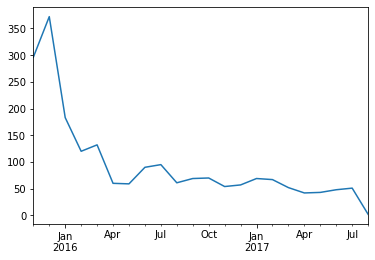

In [99]:
archive_c.year_month.value_counts().sort_index().plot()

<font color = 'red'>**First Insight:** Number of tweets is decreasing over time</font>

<font color = 'blue'>**4- Analyzing interactions over time.**</font>

In [100]:
archive_c.groupby('year_month').sum()[['favorite_count','retweet_count']]

,favorite_count,retweet_count
year_month,,
2015-11,341777,140795
2015-12,1199212,493018
2016-01,693158,263412
2016-02,453960,162297
2016-03,552634,200305
2016-04,254829,83960
2016-05,342418,116233
2016-06,850808,342399
2016-07,641613,232706


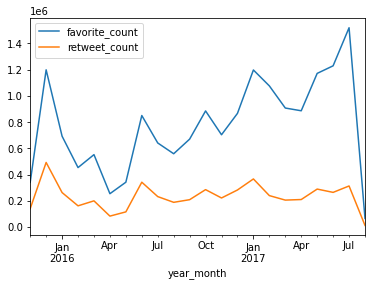

In [101]:
archive_c.groupby('year_month').sum()[['favorite_count','retweet_count']].plot()

In [102]:
#Check for the drop of numbers in August, 2017
archive_c.timestamp.max()

Timestamp('2017-08-01 16:23:56+0000', tz='UTC')

In [103]:
#As August,2017 was not completed I will exclude its rows from the time analysis and replot!
time_df = archive_c[archive_c.year_month != '2017-08']

<font color = 'blue'>**Replotting after removing August 2017**</font>

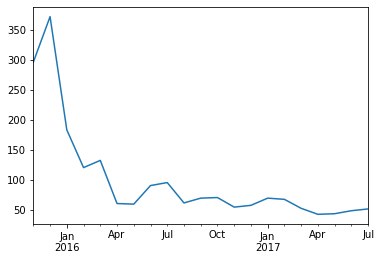

In [116]:
time_df.year_month.value_counts().sort_index().plot()

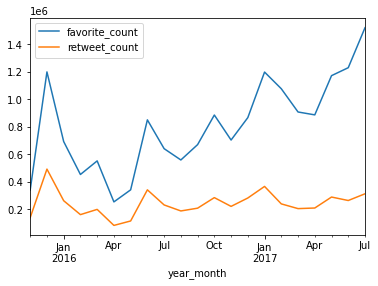

In [105]:
time_df.groupby('year_month').sum()[['favorite_count','retweet_count']].plot()

<font color = 'red'>**Second insight:** Although the number of tweets decreased, the rate of interactions is not affected accordingly, it varies with a positive trend. May be due to increasing number of followers. **This can be analyzed in a second iteration, getting number of followers from the tweets json file.**

<font color = 'blue'>**5- Now, although the dog category is incomplete, let's see the numbers for each category**</font>

In [106]:
archive_c.dog_category.value_counts()

pupper           222
doggo             72
puppo             24
floofer           10
doggo, pupper      5
Name: dog_category, dtype: int64

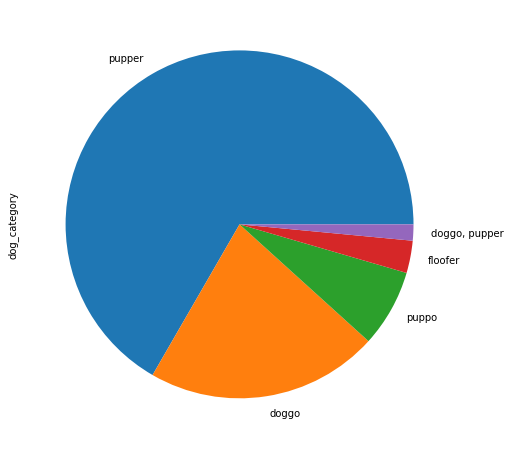

In [107]:
archive_c.dog_category.value_counts().plot.pie(figsize=(8,8))

<font color = 'blue'>**6-Analyzing count of tweets for predicted dog types.**</font>

In [108]:
#As the number of predictions is huge, I would plot only those types with more than 40 tweets
counts = archive_c.prediction.value_counts()
counts = counts[counts>40]
counts

golden_retriever      156
Labrador_retriever    106
Pembroke               94
Chihuahua              90
pug                    62
toy_poodle             50
chow                   48
Samoyed                42
Pomeranian             41
Name: prediction, dtype: int64

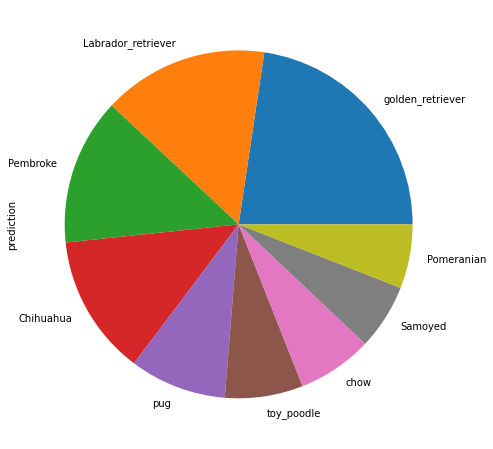

In [109]:
counts.plot.pie(figsize=(8,8))

<font color = 'red'>**Third insights:** Most tweets are for: Golden retriever, Labrador retriever, Pembroke and Chihuahua.</font>

<font color = 'blue'>**7- Let's see the top 10 average ratings**</font>

As denominator is fixed, I'll take only the nominator.

In [110]:
archive_c.groupby('prediction').mean()['rating_numerator'].sort_values(ascending= False).head(10)

prediction
Bouvier_des_Flandres    13.000000
Saluki                  12.500000
briard                  12.333333
Tibetan_mastiff         12.250000
Border_terrier          12.142857
standard_schnauzer      12.000000
silky_terrier           12.000000
Irish_setter            11.750000
Gordon_setter           11.750000
Samoyed                 11.690476
Name: rating_numerator, dtype: float64

<font color = 'blue'>**8- And now top 10 interactions.**</font>

I'll add a column named interactions, that adds favorites and retweets.

In [111]:
archive_c['interactions'] = archive_c['retweet_count'] + archive_c['favorite_count']

In [112]:
archive_c.groupby('prediction').mean()['interactions'].sort_values(ascending= False).head(10)

prediction
Bedlington_terrier         29807.000000
Saluki                     26205.500000
French_bulldog             23092.133333
Afghan_hound               20550.000000
Bouvier_des_Flandres       19952.000000
flat-coated_retriever      19130.250000
black-and-tan_coonhound    18891.000000
Irish_water_spaniel        18526.000000
whippet                    17620.818182
English_springer           17412.000000
Name: interactions, dtype: float64

<font color = 'blue'>**9- And the dog type with maximum total interactions.**</font>

In [113]:
archive_c.groupby('prediction').sum()['interactions'].sort_values(ascending= False).head(1)

prediction
golden_retriever    2278703
Name: interactions, dtype: Int64